In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../..'))

from offshore_wind_nj.config import INTERIM_DATA_DIR, ERA5_DATA_DIR
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer

# import pygrib

import xarray as xr
from scipy.spatial import cKDTree
import torch

2025-02-28 09:13:09.154 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research


In [2]:
print(xr.backends.plugins.list_engines())


{'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'cfgrib': <CfGribBackend>
  Open GRIB files (.grib, .grib2, .grb and .grb2) in Xarray
  Learn more at https://github.com/ecmwf/cfgrib, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html}


/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.26.0
  warnings.warn(


# Load the ERA5 Reanalysis dataset

In [3]:
era_path = os.path.join(ERA5_DATA_DIR, 'ERA5_2023_TO_2024.grib')

In [4]:
era5_ds = xr.open_dataset(era_path, engine='cfgrib')

/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


## Inspect ERA5 Reanalysis dataset

In [8]:
era5_ds

<xarray.Dataset> Size: 1GB
Dimensions:     (time: 17544, latitude: 45, longitude: 65)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 140kB 2023-01-01 ... 2024-12-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 360B 44.0 43.75 43.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 520B -78.0 -77.75 -77.5 ... -62.25 -62.0
    valid_time  (time) datetime64[ns] 140kB ...
Data variables:
    u10         (time, latitude, longitude) float32 205MB ...
    v10         (time, latitude, longitude) float32 205MB ...
    u100        (time, latitude, longitude) float32 205MB ...
    v100        (time, latitude, longitude) float32 205MB ...
    u10n        (time, latitude, longitude) float32 205MB ...
    v10n        (time, latitude, longitude) float32 205MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-28T09:13 GRIB to CDM+CF via cfgrib-0.9.1...

### Check the dimensions

In [9]:
era5_ds.dims

FrozenMappingWarningOnValuesAccess({'time': 17544, 'latitude': 45, 'longitude': 65})

### Check coordinates

In [10]:
era5_ds.coords

Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 140kB 2023-01-01 ... 2024-12-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 360B 44.0 43.75 43.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 520B -78.0 -77.75 -77.5 ... -62.25 -62.0
    valid_time  (time) datetime64[ns] 140kB ...

### Check data variables

In [11]:
era5_ds.variables

Frozen({'number': <xarray.Variable ()> Size: 8B
[1 values with dtype=int64]
Attributes:
    long_name:      ensemble member numerical id
    units:          1
    standard_name:  realization, 'time': <xarray.IndexVariable 'time' (time: 17544)> Size: 140kB
array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', ..., '2024-12-31T21:00:00.000000000',
       '2024-12-31T22:00:00.000000000', '2024-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time, 'step': <xarray.Variable ()> Size: 8B
[1 values with dtype=timedelta64[ns]]
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period, 'surface': <xarray.Variable ()> Size: 8B
[1 values with dtype=float64]
Attributes:
    long_name:  original GRIB coordinate for key: level(surface)
    units:      1, 'latitude': <xarray.IndexVariable 'latit

In [9]:
print(era5_ds.dims)
print(era5_ds.coords)
print(era5_ds.variables)


FrozenMappingWarningOnValuesAccess({'time': 17544, 'latitude': 45, 'longitude': 65})
Coordinates:
    number      int32 4B ...
  * time        (time) datetime64[ns] 140kB 2023-01-01 ... 2024-12-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 360B 44.0 43.75 43.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 520B -78.0 -77.75 -77.5 ... -62.25 -62.0
    valid_time  (time) datetime64[ns] 140kB ...
Frozen({'number': <xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    long_name:      ensemble member numerical id
    units:          1
    standard_name:  realization, 'time': <xarray.IndexVariable 'time' (time: 17544)> Size: 140kB
array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', ..., '2024-12-31T21:00:00.000000000',
       '2024-12-31T22:00:00.000000000', '2024-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:


### See available vars

In [12]:
era5_ds.data_vars  # See available variables.


Data variables:
    u10      (time, latitude, longitude) float32 205MB ...
    v10      (time, latitude, longitude) float32 205MB ...
    u100     (time, latitude, longitude) float32 205MB ...
    v100     (time, latitude, longitude) float32 205MB ...
    u10n     (time, latitude, longitude) float32 205MB ...
    v10n     (time, latitude, longitude) float32 205MB ...

### Compare data with Jersey Atlantic Wind Farm

In [56]:
# Find the closest latitude and longitude to (39.25, -75)
lat_idx = np.abs(era5_ds['latitude'] - 39.25).argmin()
lon_idx = np.abs(era5_ds['longitude'] - (-75)).argmin()

# Extract the u and v components of the wind at the specified location and time index 0
u_wind = era5_ds['u10'][0, lat_idx, lon_idx].values  # u-component of wind at time index 0
v_wind = era5_ds['v10'][0, lat_idx, lon_idx].values  # v-component of wind at time index 0

# Print the extracted values
print(f"u-wind: {u_wind}, v-wind: {v_wind}")

u-wind: 1.69512939453125, v-wind: 2.7671356201171875


array(1.6951294, dtype=float32)

# Extract Key variables

In [16]:
# Extract key variables
u10 = era5_ds["u10"]  # 10m wind component U
v10 = era5_ds["v10"]  # 10m wind component V
time = era5_ds["time"]
lat = era5_ds["latitude"].values
lon = era5_ds["longitude"].values

In [6]:
lat.shape

(45,)

In [7]:
len(np.array(list(zip(lat, lon)))[0])
np.array(list(zip(lat, lon)))[0]

array([ 44., -78.])

# Load Sentinel-1 Data and Match Spatially

In [8]:
from offshore_wind_nj.data_loader import data_files, load_data, all_arrays, extract_datetime_from_filename, removed_files, process_arrays
from offshore_wind_nj.sar_wind_plot import plot_wind_field, plot_wind_field_by_arrays
from offshore_wind_nj.data_cleaning import fill_zeros, find_zeros

There are 5766 files


## Use the first image to test

In [111]:
data_files[7]

PosixPath('/nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research/data/processed/S1A_IW_OCN__2SDH_20230710T105755_20230710T105818_049360_05EF7F_3CBA.npz')

In [112]:
sampe_array = all_arrays[7]

### Create a mask to exclude nan values

In [113]:
mask = ~np.isnan(sampe_array[0])

### Extract speed, direction and coordinates from Sentinel 1 dataset

In [114]:
# Extract coordinates
sentinel_speed = sampe_array[0][mask]
sentinel_dir = sampe_array[1][mask]
sentinel_lat = sampe_array[2][mask]
sentinel_lon = sampe_array[3][mask]
sentinel_lon.shape

(5115,)

### Convert wind speeds and directions in u & v vectors

In [115]:
u_sentinel = np.sin(np.radians(sentinel_dir)) * sentinel_speed
v_sentinel = np.cos(np.radians(sentinel_dir)) * sentinel_speed
v_sentinel.shape

(5115,)

## Flatenning the NumPy arrays; use ravel for better computing processing (Not needed as of 02/25)


In [116]:
sentinel_lat

array([41.711475, 41.713177, 41.702484, ..., 40.947403, 40.948895,
       40.95039 ], dtype=float32)

In [117]:
# sentinel_lat = sentinel_lat.ravel()
# sentinel_lon = sentinel_lon.ravel()

## Stack coodinates pairs

In [118]:
sentinel_coords = np.column_stack((sentinel_lat, sentinel_lon))

In [119]:
sentinel_coords.shape

(5115, 2)

## Build KDTree for fast nearest-neighbor search on GRIB data grid

In [120]:
grib_coords = np.array(np.meshgrid(lat, lon)).T.reshape(-1, 2)  # Flatten lat/lon grid
tree = cKDTree(grib_coords)

In [121]:
grib_coords.shape

(2925, 2)

## Find closest GRIB grid points for each Sentinel-1 point

In [122]:
_, idxs = tree.query(sentinel_coords)

## Extract nearest lat/lon values from GRIB

In [123]:
matched_lat_lon = grib_coords[idxs]

In [124]:
matched_lat_lon#.shape#[:, 0]

array([[ 41.75, -71.25],
       [ 41.75, -71.25],
       [ 41.75, -71.25],
       ...,
       [ 41.  , -73.75],
       [ 41.  , -73.75],
       [ 41.  , -73.75]])

# Match Temporally

## ERA5 Reanalysis dataset

In [125]:
time.values

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', ...,
       '2024-12-31T21:00:00.000000000', '2024-12-31T22:00:00.000000000',
       '2024-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [126]:
(time.values)

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', ...,
       '2024-12-31T21:00:00.000000000', '2024-12-31T22:00:00.000000000',
       '2024-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

## Sentinel 1 products dataset

### For loop for next steps...

filename_l = []
date_l = []
start_time_l = []
end_time_l = []

for i in data_files:
    filename, date, start_time, end_time = extract_datetime_from_filename(i)
    filename_l.append(filename)
    date_l.append(date)
    start_time_l.append(start_time)
    end_time_l.append(end_time)
    

### Test dataset

In [127]:
filename, date, start_time, end_time = extract_datetime_from_filename(data_files[7])

# Product from '2023-01-23'

In [128]:
filename

'S1A_IW_OCN__2SDH_20230710T105755_20230710T105818_049360_05EF7F_3CBA'

In [129]:
import re
from datetime import datetime
parts = re.split('_', filename)
datetime.strptime(parts[6], '%Y%m%dT%H%M%S')

datetime.datetime(2023, 7, 10, 10, 58, 18)

In [130]:
# Combine date and time into a single string in ISO 8601 format
sentinel_datetime_str = f"{date}T{end_time}"
sentinel_datetime = np.datetime64(sentinel_datetime_str)
# sentinel_datetime_str = np.char.add(np.char.add(date, 'T'), end_time)
# sentinel_datetime_str = sentinel_datetime_str.astype('datetime64[ns]')

In [131]:
sentinel_datetime

numpy.datetime64('2023-07-10T10:58:18')

## Convert ERA5 & Sentinel time to datetime64

### Convert ERA5 time to datetime64

In [132]:
era5_time = time.values  # ERA5 time as datetime64
era5_time

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', ...,
       '2024-12-31T21:00:00.000000000', '2024-12-31T22:00:00.000000000',
       '2024-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

### Convert Sentinel datetime to match ERA5 format

In [133]:
sentinel_datetime = np.datetime64(sentinel_datetime_str)
sentinel_datetime

numpy.datetime64('2023-07-10T10:58:18')

In [134]:
era5_time - sentinel_datetime

array([-16455498000000000, -16451898000000000, -16448298000000000, ...,
        46692102000000000,  46695702000000000,  46699302000000000],
      dtype='timedelta64[ns]')

In [135]:
len(era5_time)

17544

In [136]:
# Find the closest time index
time_idx = np.argmin(np.abs(era5_time - sentinel_datetime))

# Get the matched ERA5 time
matched_era5_time = era5_time[time_idx]

In [137]:
# Convert datetime64 to integer timestamp (nanoseconds)
matched_era5_time_int = matched_era5_time.astype('int64')

In [138]:
matched_era5_time

numpy.datetime64('2023-07-10T11:00:00.000000000')

In [139]:
time_idx

4571

In [140]:
u10[3995]

<xarray.DataArray 'u10' (latitude: 45, longitude: 65)> Size: 12kB
[2925 values with dtype=float32]
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B 2023-06-16T11:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 360B 44.0 43.75 43.5 ... 33.5 33.25 33.0
  * longitude   (longitude) float64 520B -78.0 -77.75 -77.5 ... -62.25 -62.0
    valid_time  datetime64[ns] 8B ...
Attributes: (12/31)
    GRIB_paramId:                             165
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      2925
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           10u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown

In [141]:
# Extract ERA5 wind components at the matched time index
u10_matched = u10.isel(time=time_idx).values
v10_matched = v10.isel(time=time_idx).values


In [142]:
# match time & coordinates
u10_matched = u10_matched.ravel()[idxs]
v10_matched = v10_matched.ravel()[idxs]

In [143]:
# u10_sentinel = u10_matched.ravel()[idxs]
# v10_sentinel = v10_matched.ravel()[idxs]
matched_era5_time_int

1688986800000000000

In [144]:
u10_matched.shape

(5115,)

In [145]:
combined_data = np.column_stack((
    sentinel_coords,    # (5115, 2) → Sentinel lat/lon
    matched_lat_lon,    # (5115, 2) → Matched ERA5 lat/lon
    u_sentinel, v_sentinel,  # (5115,) → Sentinel wind vectors
    u10_matched, v10_matched,  # (5115,) → ERA5 wind vectors
    np.full(len(sentinel_coords), matched_era5_time_int)  # (5115,) → Time
))

In [146]:
for i in combined_data[100]:
    print (i)

41.32596969604492
-71.48783111572266
41.25
-71.5
-6.230957984924316
4.351455211639404
-5.357940673828125
2.731781005859375
1.6889868e+18


# Check if they correlate or not

In [147]:
from scipy.stats import pearsonr

# Compute correlation for U-components
corr_u, p_value_u = pearsonr(u_sentinel, u10_matched)

# Compute correlation for V-components
corr_v, p_value_v = pearsonr(v_sentinel, v10_matched)

print(f"Pearson correlation for U-components: {corr_u:.3f} (p-value: {p_value_u:.3E})")
print(f"Pearson correlation for V-components: {corr_v:.3f} (p-value: {p_value_v:.3E})")


Pearson correlation for U-components: 0.742 (p-value: 0.000E+00)
Pearson correlation for V-components: 0.667 (p-value: 0.000E+00)


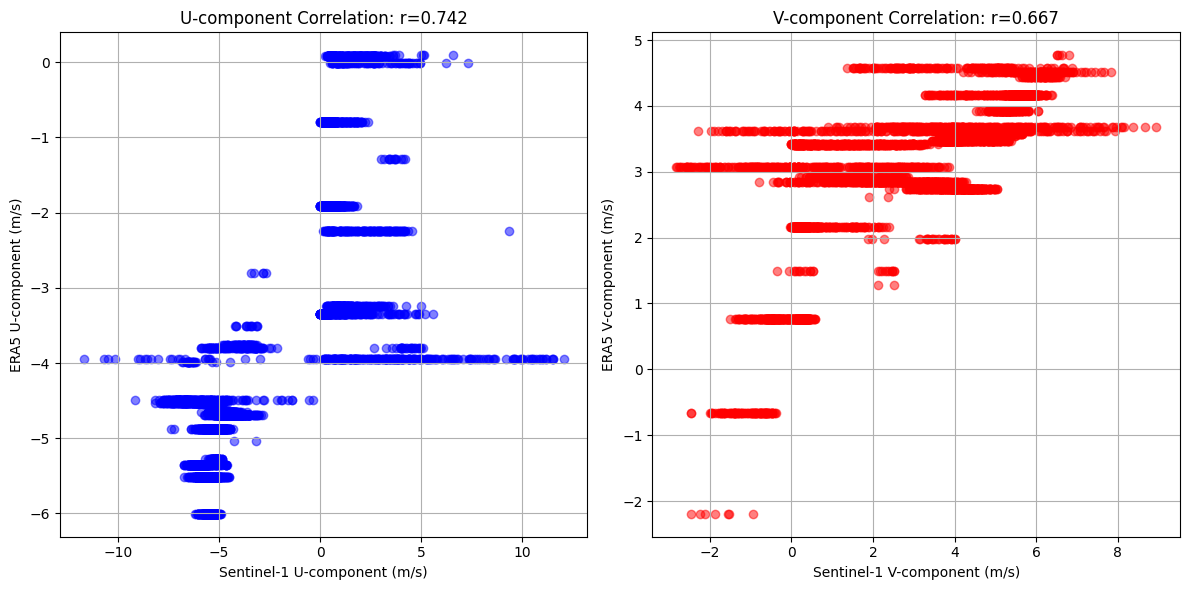

In [148]:
import matplotlib.pyplot as plt

# Plot for U-component correlation
plt.figure(figsize=(12, 6))

# U-component scatter plot
plt.subplot(1, 2, 1)
plt.scatter(u_sentinel, u10_matched, alpha=0.5, color='b')
plt.xlabel("Sentinel-1 U-component (m/s)")
plt.ylabel("ERA5 U-component (m/s)")
plt.title(f"U-component Correlation: r={corr_u:.3f}")
plt.grid(True)

# V-component scatter plot
plt.subplot(1, 2, 2)
plt.scatter(v_sentinel, v10_matched, alpha=0.5, color='r')
plt.xlabel("Sentinel-1 V-component (m/s)")
plt.ylabel("ERA5 V-component (m/s)")
plt.title(f"V-component Correlation: r={corr_v:.3f}")
plt.grid(True)

plt.tight_layout()
plt.show()


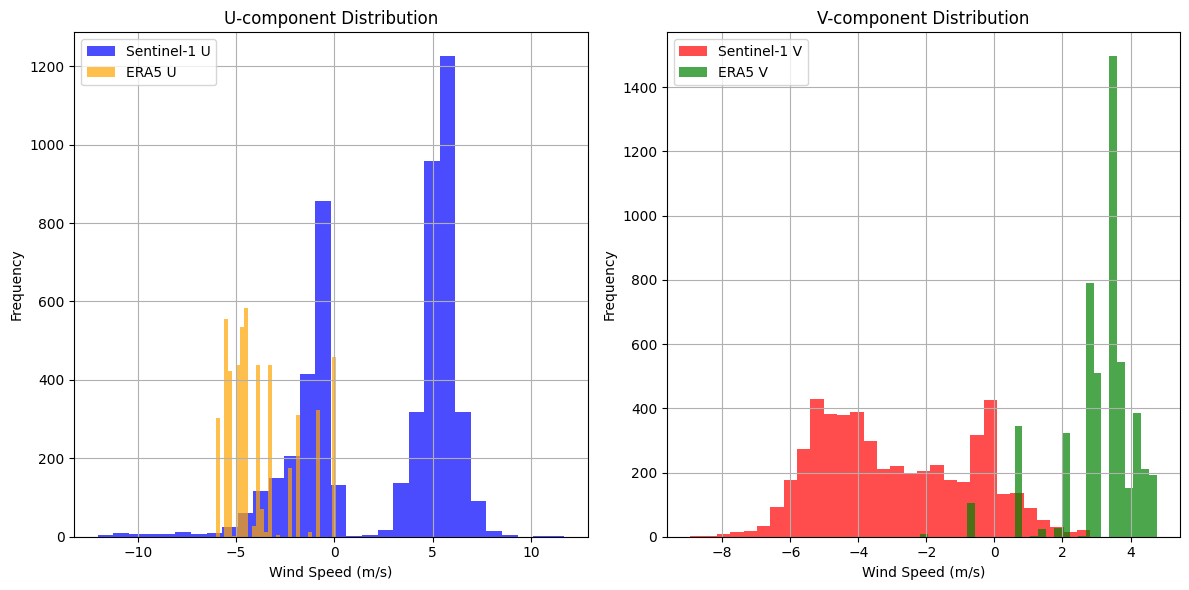

In [109]:
plt.figure(figsize=(12, 6))

# U-component histogram
plt.subplot(1, 2, 1)
plt.hist(u_sentinel, bins=30, alpha=0.7, label='Sentinel-1 U', color='blue')
plt.hist(u10_matched, bins=30, alpha=0.7, label='ERA5 U', color='orange')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.title("U-component Distribution")
plt.legend()
plt.grid(True)

# V-component histogram
plt.subplot(1, 2, 2)
plt.hist(v_sentinel, bins=30, alpha=0.7, label='Sentinel-1 V', color='red')
plt.hist(v10_matched, bins=30, alpha=0.7, label='ERA5 V', color='green')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.title("V-component Distribution")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [47]:
df

NameError: name 'df' is not defined

In [ ]:
# Convert GRIB and Sentinel-1 times to pandas DateTime format
grib_times = pd.to_datetime(ds["time"].values)
sentinel_df["datetime"] = pd.to_datetime(sentinel_df["timestamp"])  # Assuming Sentinel timestamps

# Find closest GRIB timestamp for each Sentinel-1 record
sentinel_df["matched_time"] = sentinel_df["datetime"].apply(lambda x: grib_times[np.argmin(np.abs(grib_times - x))])


# Extract Wind Data

In [ ]:
# Function to extract wind data from GRIB dataset
def get_grib_wind(lat, lon, time):
    return ds.sel(latitude=lat, longitude=lon, time=time, method="nearest")

# Apply to Sentinel-1 matched points
sentinel_df["u10"] = sentinel_df.apply(lambda row: get_grib_wind(row.matched_lat, row.matched_lon, row.matched_time)["u10"].values, axis=1)
sentinel_df["v10"] = sentinel_df.apply(lambda row: get_grib_wind(row.matched_lat, row.matched_lon, row.matched_time)["v10"].values, axis=1)


# Sample code on 02/19/2025

# Reproject coordinate reference system


In [9]:
# Define the source and target CRS (WGS84 to LCC)
source_crs = "EPSG:4326"  # WGS84 (lat/lon)
target_crs = '+proj=lcc +lat_1=34.45660400390625 +lat_2=43.251747131347656 +lon_0=-71.37067794799805 +lat_0=38.85417556762695 +datum=WGS84'

# Create a Transformer object for converting from WGS84 to LCC
transformer = Transformer.from_crs(source_crs, target_crs)

# Convert lat/lon to projected x, y coordinates
# df['x'], df['y'] = transformer.transform(df['Lat'].values, df['Lon'].values)

In [8]:
# Check the coordinates (e.g., time, lat, lon)
print(ds.coords)

# Access specific coordinates, e.g., latitude and longitude
print(ds.coords['latitude'])
print(ds.coords['longitude'])


Coordinates:
    number         int64 8B ...
  * time           (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
    step           timedelta64[ns] 8B ...
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 312B 43.5 43.25 43.0 ... 34.5 34.25 34.0
  * longitude      (longitude) float64 344B -76.5 -76.25 -76.0 ... -66.25 -66.0
    valid_time     (time) datetime64[ns] 70kB ...
<xarray.DataArray 'latitude' (latitude: 39)> Size: 312B
array([43.5 , 43.25, 43.  , 42.75, 42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25,
       41.  , 40.75, 40.5 , 40.25, 40.  , 39.75, 39.5 , 39.25, 39.  , 38.75,
       38.5 , 38.25, 38.  , 37.75, 37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25,
       36.  , 35.75, 35.5 , 35.25, 35.  , 34.75, 34.5 , 34.25, 34.  ])
Coordinates:
    number         int64 8B ...
    step           timedelta64[ns] 8B ...
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 312B 43.5 43.25 43.0 ... 34.5 34.25 34.0
Attributes:
    units:         

Do I have to match Sentinel-1 products one by one?
Yes, since Sentinel-1 provides discrete SAR images with different timestamps and locations, you’ll need to process each product separately. The workflow would look like this:

Loop through Sentinel-1 products
Read the metadata (timestamp, lat/lon grid).
Find the closest GRIB timestamps and grid points.
Extract the corresponding wind data.
Store results
Save the matched data for each Sentinel-1 product.
Combine results into a larger dataset if needed.
If you're dealing with many Sentinel-1 products, consider automating the process with a script that loops through all available images.

2. How does the nearest-neighbor search work?
We use k-dimensional tree (KDTree) from scipy.spatial.cKDTree to efficiently find the nearest point in your GRIB grid. Here’s how it works:

Convert GRIB grid points into a KDTree

This organizes latitude-longitude points into a data structure optimized for fast searching.
It reduces the computational cost from O(n) (brute force) to O(log n) (KDTree search).
Query the nearest neighbor for each Sentinel-1 coordinate

For every Sentinel-1 lat/lon, the KDTree finds the closest GRIB grid point using Euclidean distance in 2D space.
💡 Alternative: Instead of a pure nearest-neighbor approach, you could use bilinear interpolation to compute values from the four nearest grid points.

3. Should I project coordinates before matching?
Using latitude and longitude directly assumes distances are uniform, which is not true, especially at high latitudes.

The Earth is not a perfect sphere; distances in degrees vary depending on location.
Using (lat, lon) as if they were Cartesian coordinates can introduce small errors.
Best Approach: Use an Equal-Area Projection (like Lambert)
Why?

It preserves distances locally, making nearest-neighbor searches more accurate.
Wind data typically benefits from Lambert Conformal Conic (LCC) projection, commonly used for meteorological models.
How to Reproject to Lambert Projection (EPSG:4326 → EPSG:3031 or LCC)?
You can transform the coordinates using pyproj:

python
Copy
Edit
from pyproj import Transformer

# Define transformation from WGS84 (lat/lon) to Lambert projection
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)

# Convert GRIB coordinates
grib_x, grib_y = transformer.transform(lon, lat)

# Convert Sentinel-1 coordinates
sentinel_x, sentinel_y = transformer.transform(sentinel_df["lon"], sentinel_df["lat"])
Now, use (grib_x, grib_y) instead of (lat, lon) in the KDTree nearest-neighbor search.

What If You Skip Projection?
If your study area is small (e.g., offshore wind near New Jersey), errors may be minor.
If working globally, projection is highly recommended.
Final Thoughts
If Sentinel-1 images are spread over time and space, loop through them product by product.
Using KDTree nearest-neighbor is fast, but consider bilinear interpolation for smoother values.
Projecting to Lambert (or another suitable projection) is best, especially for accurate spatial matching.
Would you like help implementing the Lambert projection step in your workflow? 🚀